In [1]:
### IMPORT BIBLIOTECAS

import requests
import re
import matplotlib
import matplotlib.pyplot as plt
import seaborn  as sns
import pandas as pd
from bs4 import BeautifulSoup
import numpy as np
import folium
import json
from tqdm.auto import tqdm
from datetime import datetime

C:\Users\Matheus\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
data = pd.read_csv('data-extraction-and-transform/flights_brazil_2019.csv', compression = 'gzip')
data.head()

C:\Users\Matheus\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (0,23) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,nr_voo,empresa_aerea,cd_tipo_linha,cidade_origem,cidade_destino,pais_origem,pais_destino,dt_partida_prevista,dt_partida_real,dt_chegada_prevista,...,dia_semana,mes,ano,atraso_chegada_min,atraso_partida_min,latitude_origem,latitude_destino,longitude_origem,longitude_destino,cd_di
0,35,NaN,Internacional,PARIS,CAMPINAS,FRANCA,BRASIL,2019-01-25 06:15:00,2019-01-25 06:15:00,2019-01-25 18:15:00,...,6 - Sexta,01 - Janeiro,2019.0,0.0,0.0,48.723333,-23.007401,2.379444,-47.134499,0
1,35,NaN,Internacional,PARIS,CAMPINAS,FRANCA,BRASIL,2019-01-27 06:15:00,2019-01-27 06:15:00,2019-01-27 18:15:00,...,1 - Domingo,01 - Janeiro,2019.0,0.0,0.0,48.723333,-23.007401,2.379444,-47.134499,0
2,35,NaN,Internacional,PARIS,CAMPINAS,FRANCA,BRASIL,2019-01-29 06:15:00,2019-01-29 06:15:00,2019-01-29 18:15:00,...,3 - Terça,01 - Janeiro,2019.0,0.0,0.0,48.723333,-23.007401,2.379444,-47.134499,0
3,36,NaN,Internacional,CAMPINAS,PARIS,BRASIL,FRANCA,2019-01-25 20:15:00,2019-01-25 20:15:00,2019-01-26 07:45:00,...,6 - Sexta,01 - Janeiro,2019.0,0.0,0.0,-23.007401,48.723333,-47.134499,2.379444,0
4,36,NaN,Internacional,CAMPINAS,PARIS,BRASIL,FRANCA,2019-01-27 20:15:00,2019-01-27 20:15:00,2019-01-28 07:45:00,...,1 - Domingo,01 - Janeiro,2019.0,0.0,0.0,-23.007401,48.723333,-47.134499,2.379444,0


# divisao chegada/partida
## status voos no brasil
• cidade com mais voos

• voos por categoria

• dia da semana com mais voos

• dia do mes com mais voos

• voos por mes


## status atrasos de voos no brasil
• cidade com mais atrasos

• cidade com mais atrasos relativo %

• atraso medio por cidade

• atraso medio por mes da cidade com mais voo

• atraso voos nacionais e internacionais

• dia da semana com mais atrasos e atraso médio

• dia do mes com mais atrasos e atraso médio

• atrasos por mes

• minutos de atraso por mes


# Status voos no Brasil

## Cidades com mais voos

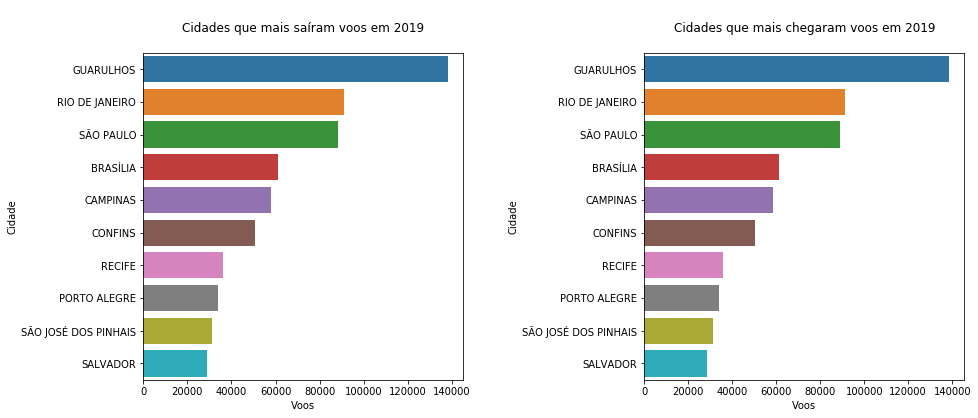

In [105]:
# Foram considerados os 10 maiores valores


maissaivoo = data[['cidade_origem','dia']].groupby('cidade_origem').count().sort_values(by = 'dia', ascending = False).reset_index().head(10)
maischegavoo = data[['cidade_destino','dia']].groupby('cidade_destino').count().sort_values(by = 'dia', ascending = False).reset_index().head(10)

fig, ax = plt.subplots(1,2, figsize = (16, 9))
fig.tight_layout(pad = 15)

sns.barplot(y = 'cidade_origem', x = 'dia', data = maissaivoo, ax = ax[0])
ax[0].set_xlabel('Voos')
ax[0].set_ylabel('Cidade')
ax[0].set_title('\nCidades que mais saíram voos em 2019\n')

sns.barplot(y = 'cidade_destino', x ='dia', data = maischegavoo, ax = ax[1])
ax[1].set_xlabel('Voos')
ax[1].set_ylabel('Cidade')
ax[1].set_title('\nCidades que mais chegaram voos em 2019\n');

## Voos por categoria

In [44]:
# data possui uma categoria errada ("E"), irá ser dropada para a análise
index = data[data['cd_tipo_linha'] == 'E'].index[0]

,cd_tipo_linha,dia
0,Nacional,814384
1,Internacional,143343
2,Cargueiro internacional,17987
3,Cargueiro,6716
4,Rede postal,502
5,Regional,43


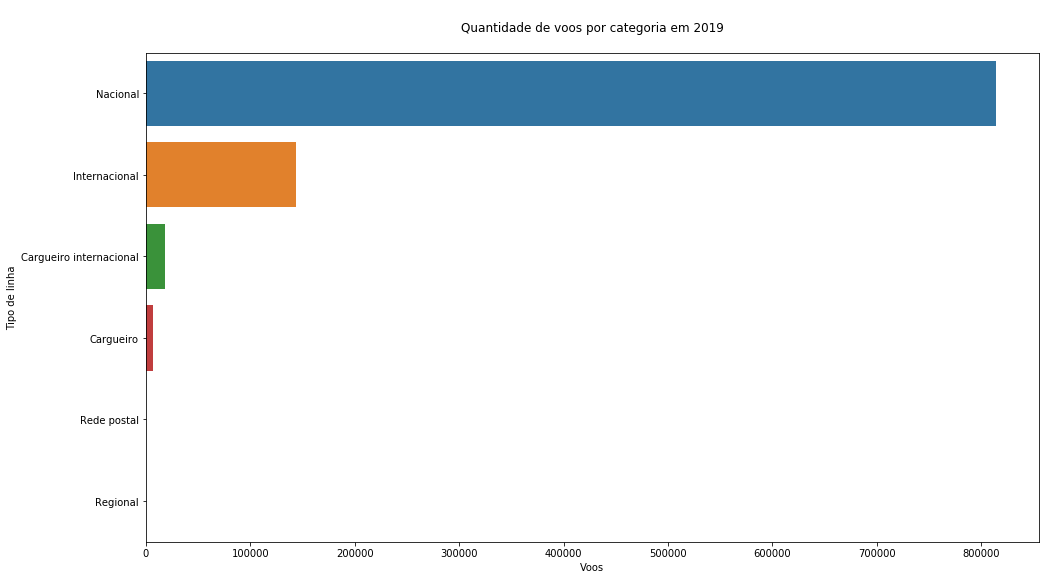

In [106]:
conttipo = data.drop(index)[['cd_tipo_linha','dia']].groupby('cd_tipo_linha').count().sort_values(by = 'dia', ascending = False).reset_index()

fig, ax = plt.subplots(figsize = (16, 9))

sns.barplot(y = 'cd_tipo_linha', x = 'dia', data = conttipo, ax = ax)
ax.set_xlabel('Voos')
ax.set_ylabel('Tipo de linha')
ax.set_title('\nQuantidade de voos por categoria em 2019\n');

# neste caso será mostrado o display da tabela com intuíto de mostrar que os valroes
# de 'rede postal' e 'regional' não são zero
display(conttipo)

## Dia da semana com mais voos

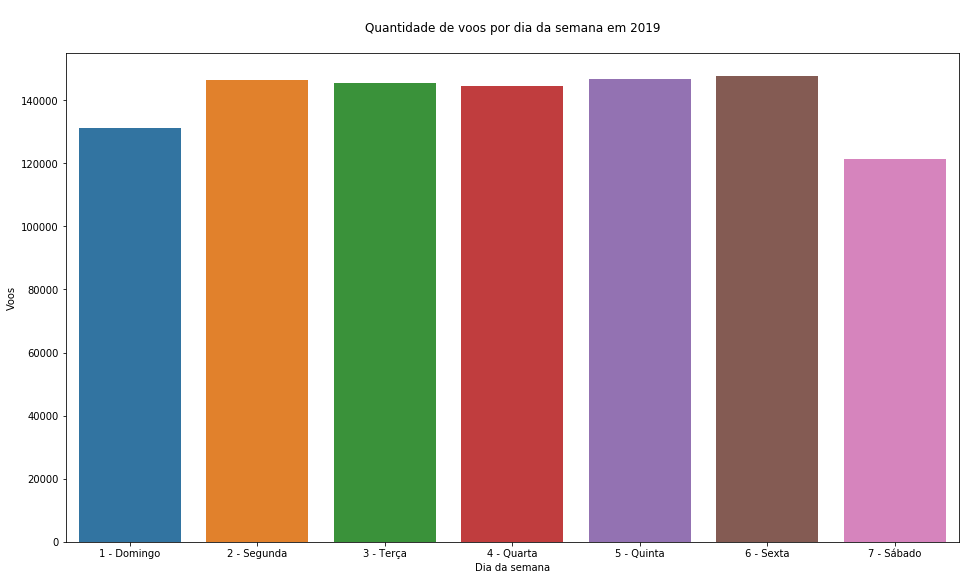

In [107]:
partida = data[['dia_semana','dia']].groupby('dia_semana').count().reset_index()

fig, ax = plt.subplots(figsize = (16, 9))

sns.barplot(x = 'dia_semana', y = 'dia', data = partida, ax = ax)
ax.set_xlabel('Dia da semana')
ax.set_ylabel('Voos')
ax.set_title('\nQuantidade de voos por dia da semana em 2019\n');


## Dia do mes com mais voos

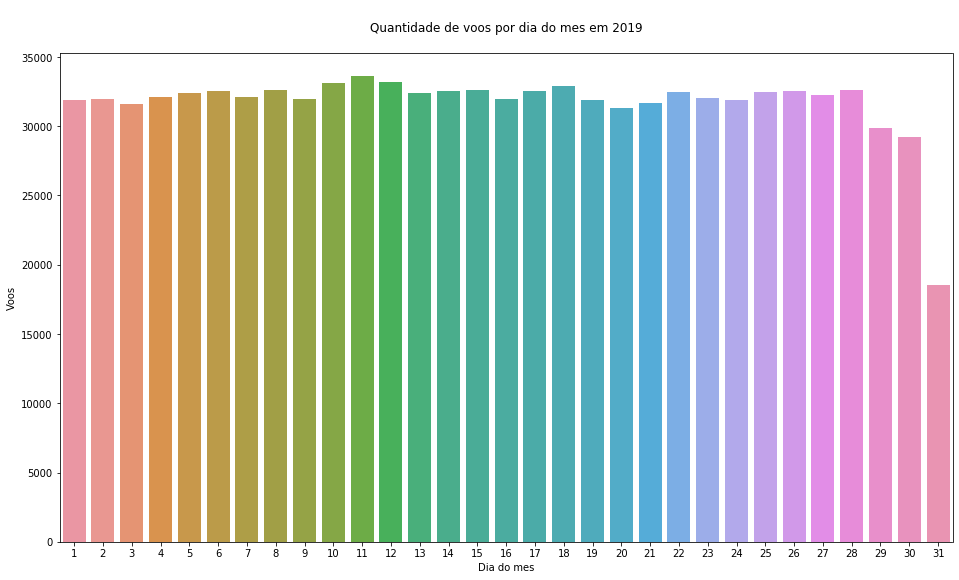

In [108]:
partida = data[['dia','mes']].groupby('dia').count().reset_index()
partida['dia'] = partida['dia'].astype('int64')
fig, ax = plt.subplots(figsize = (16, 9))

sns.barplot(x = 'dia', y = 'mes', data = partida, ax = ax)
ax.set_xlabel('Dia do mes')
ax.set_ylabel('Voos')
ax.set_title('\nQuantidade de voos por dia do mes em 2019\n');

## Quantidade de voos por mes

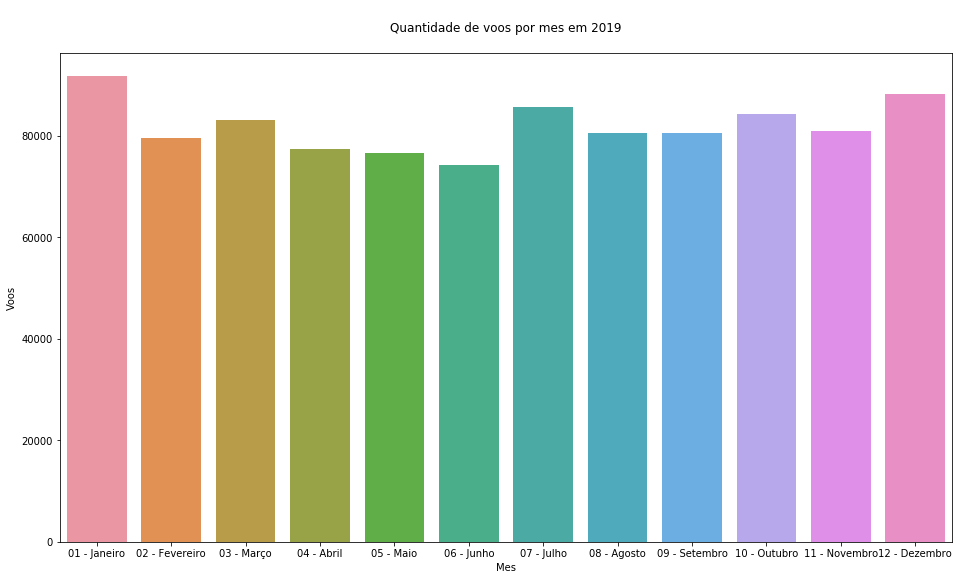

In [109]:
partida = data[['mes','dia']].groupby('mes').count().reset_index()

fig, ax = plt.subplots(figsize = (16, 9))

sns.barplot(x = 'mes', y = 'dia', data = partida, ax = ax)
ax.set_xlabel('Mes')
ax.set_ylabel('Voos')
ax.set_title('\nQuantidade de voos por mes em 2019\n');

# Status atrasos de voos no Brasil

## Cidades com mais voos atrasados

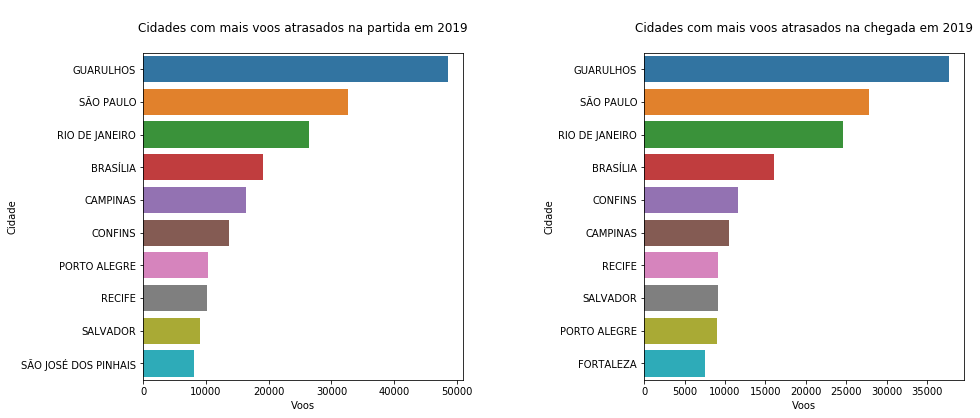

In [103]:
# Foram considerados apenas voos do tipo 'Nacional' e 'Internacional'
# Foram considerados apenas atrasos > 0 e <= 2880 min (2 dias) -- Desconsiderando voos adiantados e atrasos maiores que 2 dias erros de digitação/outliers 
# Foram considerados os 10 maiores valores


partida = data[['cidade_origem','dia', 'cd_tipo_linha']][(data['atraso_partida_min'] > 0) & (data['atraso_partida_min'] <= 2880) & (data['cd_tipo_linha'].isin(['Nacional', 'Internacional']))].groupby('cidade_origem').count().sort_values(by = 'dia', ascending = False).reset_index().head(10)
destino = data[['cidade_destino','dia', 'cd_tipo_linha']][(data['atraso_chegada_min'] > 0) & (data['atraso_chegada_min'] <= 2880) & (data['cd_tipo_linha'].isin(['Nacional', 'Internacional']))].groupby('cidade_destino').count().sort_values(by = 'dia', ascending = False).reset_index().head(10)

fig, ax = plt.subplots(1,2, figsize = (16, 9))
fig.tight_layout(pad = 15)

sns.barplot(y = 'cidade_origem', x = 'dia', data = partida, ax = ax[0])
ax[0].set_xlabel('Voos')
ax[0].set_ylabel('Cidade')
ax[0].set_title('\nCidades com mais voos atrasados na partida em 2019\n')

sns.barplot(y = 'cidade_destino', x ='dia', data = destino, ax = ax[1])
ax[1].set_xlabel('Voos')
ax[1].set_ylabel('Cidade')
ax[1].set_title('\nCidades com mais voos atrasados na chegada em 2019\n');

## Cidade com mais atrasos relativo %

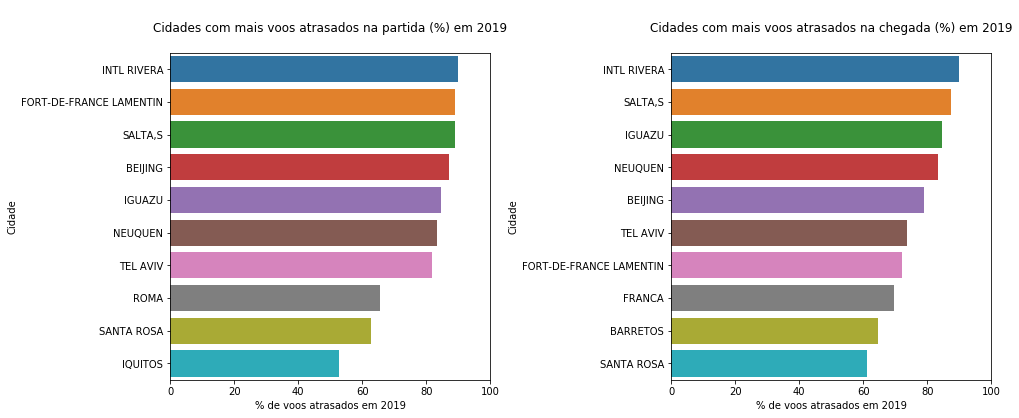

In [104]:
# Foram considerados apenas voos do tipo 'Nacional' e 'Internacional'
# Foram considerados apenas atrasos > 0 e <= 2880 min (2 dias) -- Desconsiderando voos adiantados e atrasos maiores que 2 dias erros de digitação/outliers 
# Foram considerados os 10 maiores valores


voosatrasados_partida = data[['cidade_origem','dia', 'cd_tipo_linha']][(data['atraso_partida_min'] > 0) & (data['atraso_partida_min'] <= 2880) & (data['cd_tipo_linha'].isin(['Nacional', 'Internacional']))].groupby('cidade_origem').count().reset_index()
voos_partida = data[['cidade_origem','dia']].groupby('cidade_origem').count().reset_index()
partida = voosatrasados_partida.merge(voos_partida, on = 'cidade_origem')
partida['%'] = partida['dia_x']*100/partida['dia_y']
partida = partida.sort_values(by = '%', ascending = False).head(10)


voosatrasados_destino = data[['cidade_destino','dia', 'cd_tipo_linha']][(data['atraso_chegada_min'] > 0) & (data['atraso_chegada_min'] <= 2880) & (data['cd_tipo_linha'].isin(['Nacional', 'Internacional']))].groupby('cidade_destino').count().reset_index()
voos_destino = data[['cidade_destino','dia']].groupby('cidade_destino').count().reset_index()
destino = voosatrasados_destino.merge(voos_destino, on = 'cidade_destino')
destino['%'] = destino['dia_x']*100/destino['dia_y']
destino = destino.sort_values(by = '%', ascending = False).head(10)

fig, ax = plt.subplots(1,2, figsize = (16, 9))
fig.tight_layout(pad = 15)

sns.barplot(y = 'cidade_origem', x = '%', data = partida, ax = ax[0])
ax[0].set_xlabel('% de voos atrasados em 2019')
ax[0].set_ylabel('Cidade')
ax[0].set_title('\nCidades com mais voos atrasados na partida (%) em 2019\n')
ax[0].set_xlim(0,100)

sns.barplot(y = 'cidade_destino', x ='%', data = destino, ax = ax[1])
ax[1].set_xlabel('% de voos atrasados em 2019')
ax[1].set_ylabel('Cidade')
ax[1].set_title('\nCidades com mais voos atrasados na chegada (%) em 2019\n')
ax[1].set_xlim(0,100);

## Atraso médio por cidade

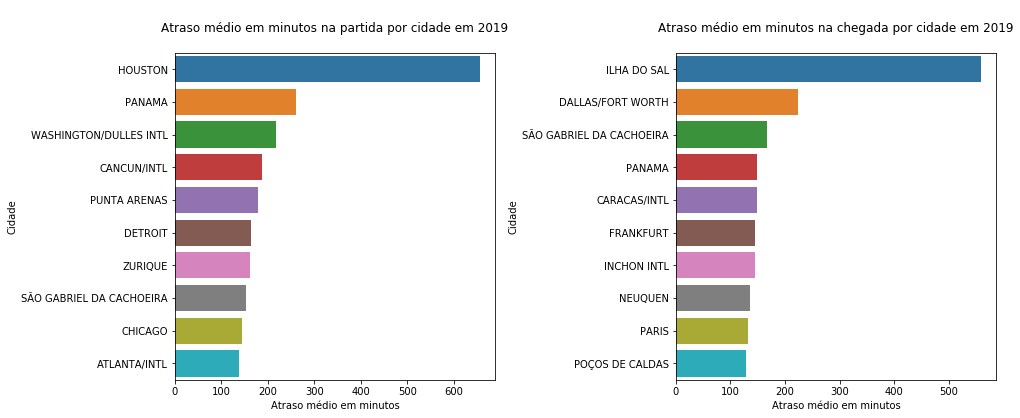

In [102]:
# Foram considerados apenas voos do tipo 'Nacional' e 'Internacional'
# Foram considerados apenas atrasos > 0 e <= 2880 min (2 dias) -- Desconsiderando voos adiantados e atrasos maiores que 2 dias erros de digitação/outliers 
# Foram considerados os 10 maiores valores

partida = data[['cidade_origem','atraso_partida_min', 'cd_tipo_linha']][(data['atraso_partida_min'] > 0) & (data['atraso_partida_min'] <= 2880) & (data['cd_tipo_linha'].isin(['Nacional', 'Internacional']))].groupby('cidade_origem').mean().sort_values(by = 'atraso_partida_min', ascending = False).reset_index().head(10)
destino = data[['cidade_destino','atraso_chegada_min', 'cd_tipo_linha']][(data['atraso_chegada_min'] > 0) & (data['atraso_chegada_min'] <= 2880) & (data['cd_tipo_linha'].isin(['Nacional', 'Internacional']))].groupby('cidade_destino').mean().sort_values(by = 'atraso_chegada_min', ascending = False).reset_index().head(10)

fig, ax = plt.subplots(1,2, figsize = (16, 9))
fig.tight_layout(pad = 15)

sns.barplot(y = 'cidade_origem', x = 'atraso_partida_min', data = partida, ax = ax[0])
ax[0].set_xlabel('Atraso médio em minutos')
ax[0].set_ylabel('Cidade')
ax[0].set_title('\nAtraso médio em minutos na partida por cidade em 2019\n')

sns.barplot(y = 'cidade_destino', x ='atraso_chegada_min', data = destino, ax = ax[1])
ax[1].set_xlabel('Atraso médio em minutos')
ax[1].set_ylabel('Cidade')
ax[1].set_title('\nAtraso médio em minutos na chegada por cidade em 2019\n');

## Atraso médio por dia da semana em Guarulhos

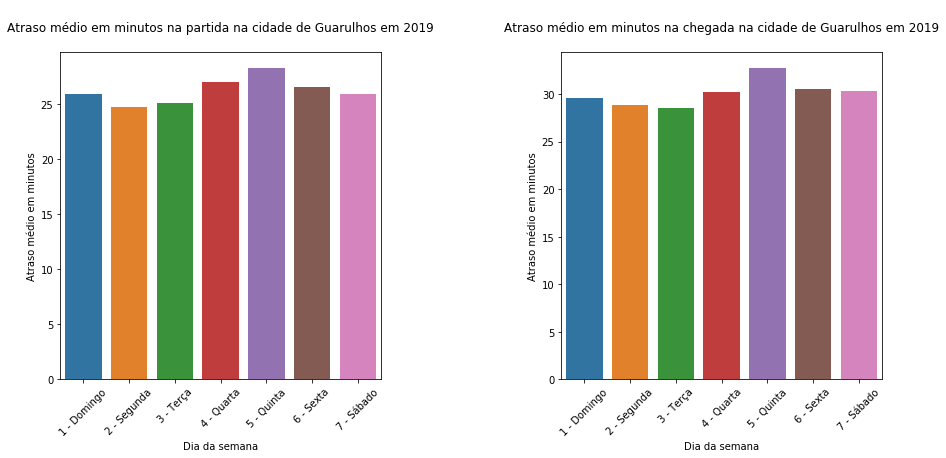

In [129]:
# Foram considerados apenas voos do tipo 'Nacional' e 'Internacional'
# Foram considerados apenas atrasos > 0 e <= 2880 min (2 dias) -- Desconsiderando voos adiantados e atrasos maiores que 2 dias erros de digitação/outliers 
# Foram considerados os 10 maiores valores

partida = data[['cidade_origem','atraso_partida_min', 'cd_tipo_linha', 'dia_semana']][(data['atraso_partida_min'] > 0) & (data['atraso_partida_min'] <= 2880) & (data['cd_tipo_linha'].isin(['Nacional', 'Internacional'])) & (data['cidade_origem'] == 'GUARULHOS')].groupby('dia_semana').mean().reset_index()
destino = data[['cidade_destino','atraso_chegada_min', 'cd_tipo_linha', 'dia_semana']][(data['atraso_chegada_min'] > 0) & (data['atraso_chegada_min'] <= 2880) & (data['cd_tipo_linha'].isin(['Nacional', 'Internacional'])) & (data['cidade_origem'] == 'GUARULHOS')].groupby('dia_semana').mean().reset_index()

fig, ax = plt.subplots(1,2, figsize = (16, 9))
fig.tight_layout(pad = 15)

sns.barplot(y = 'atraso_partida_min', x = 'dia_semana', data = partida, ax = ax[0], )
ax[0].set_xlabel('Dia da semana')
ax[0].set_ylabel('Atraso médio em minutos')
ax[0].set_title('\nAtraso médio em minutos na partida na cidade de Guarulhos em 2019\n')
ax[0].set_xticklabels(partida['dia_semana'], rotation=45)


sns.barplot(y = 'atraso_chegada_min', x ='dia_semana', data = destino, ax = ax[1])
ax[1].set_xlabel('Dia da semana')
ax[1].set_ylabel('Atraso médio em minutos')
ax[1].set_title('\nAtraso médio em minutos na chegada na cidade de Guarulhos em 2019\n')
ax[1].set_xticklabels(destino['dia_semana'], rotation=45);

## Atraso médio por mes em Guarulhos

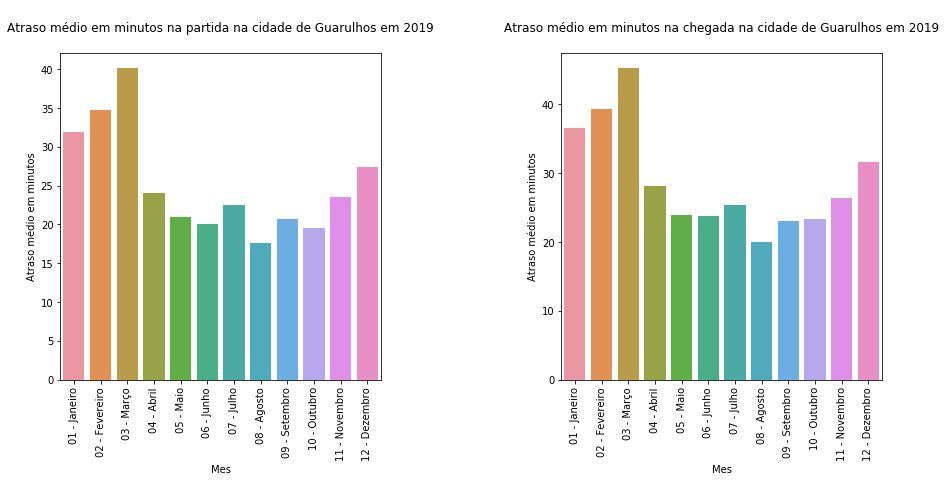

In [133]:
# Foram considerados apenas voos do tipo 'Nacional' e 'Internacional'
# Foram considerados apenas atrasos > 0 e <= 2880 min (2 dias) -- Desconsiderando voos adiantados e atrasos maiores que 2 dias erros de digitação/outliers 
# Foram considerados os 10 maiores valores

partida = data[['cidade_origem','atraso_partida_min', 'cd_tipo_linha', 'mes']][(data['atraso_partida_min'] > 0) & (data['atraso_partida_min'] <= 2880) & (data['cd_tipo_linha'].isin(['Nacional', 'Internacional'])) & (data['cidade_origem'] == 'GUARULHOS')].groupby('mes').mean().reset_index()
destino = data[['cidade_destino','atraso_chegada_min', 'cd_tipo_linha', 'mes']][(data['atraso_chegada_min'] > 0) & (data['atraso_chegada_min'] <= 2880) & (data['cd_tipo_linha'].isin(['Nacional', 'Internacional'])) & (data['cidade_origem'] == 'GUARULHOS')].groupby('mes').mean().reset_index()

fig, ax = plt.subplots(1,2, figsize = (16, 9))
fig.tight_layout(pad = 15)

sns.barplot(y = 'atraso_partida_min', x = 'mes', data = partida, ax = ax[0], )
ax[0].set_xlabel('Mes')
ax[0].set_ylabel('Atraso médio em minutos')
ax[0].set_title('\nAtraso médio em minutos na partida na cidade de Guarulhos em 2019\n')
ax[0].set_xticklabels(partida['mes'], rotation=90)


sns.barplot(y = 'atraso_chegada_min', x ='mes', data = destino, ax = ax[1])
ax[1].set_xlabel('Mes')
ax[1].set_ylabel('Atraso médio em minutos')
ax[1].set_title('\nAtraso médio em minutos na chegada na cidade de Guarulhos em 2019\n')
ax[1].set_xticklabels(destino['mes'], rotation=90);

## Atraso voos nacionais e internacionais

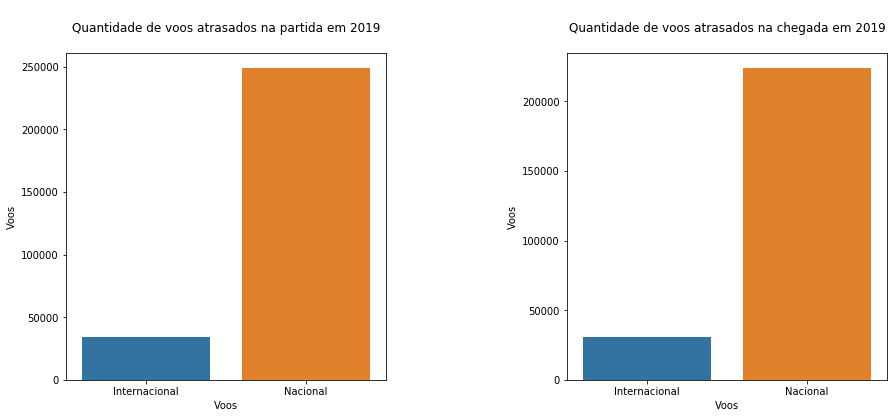

In [142]:
# Foram considerados apenas voos do tipo 'Nacional' e 'Internacional'
# Foram considerados apenas atrasos > 0 e <= 2880 min (2 dias) -- Desconsiderando voos adiantados e atrasos maiores que 2 dias erros de digitação/outliers 


partida = data[['cidade_origem','dia', 'cd_tipo_linha']][(data['atraso_partida_min'] > 0) & (data['atraso_partida_min'] <= 2880) & (data['cd_tipo_linha'].isin(['Nacional', 'Internacional']))].groupby('cd_tipo_linha').count().reset_index()
destino = data[['cidade_destino','dia', 'cd_tipo_linha']][(data['atraso_chegada_min'] > 0) & (data['atraso_chegada_min'] <= 2880) & (data['cd_tipo_linha'].isin(['Nacional', 'Internacional']))].groupby('cd_tipo_linha').count().reset_index()

fig, ax = plt.subplots(1,2, figsize = (16, 9))
fig.tight_layout(pad = 15)

sns.barplot(x = 'cd_tipo_linha', y = 'dia', data = partida, ax = ax[0])
ax[0].set_xlabel('Voos')
ax[0].set_ylabel('Voos')
ax[0].set_title('\nQuantidade de voos atrasados na partida em 2019\n')

sns.barplot(x = 'cd_tipo_linha', y ='dia', data = destino, ax = ax[1])
ax[1].set_xlabel('Voos')
ax[1].set_ylabel('Voos')
ax[1].set_title('\nQuantidade de voos atrasados na chegada em 2019\n');

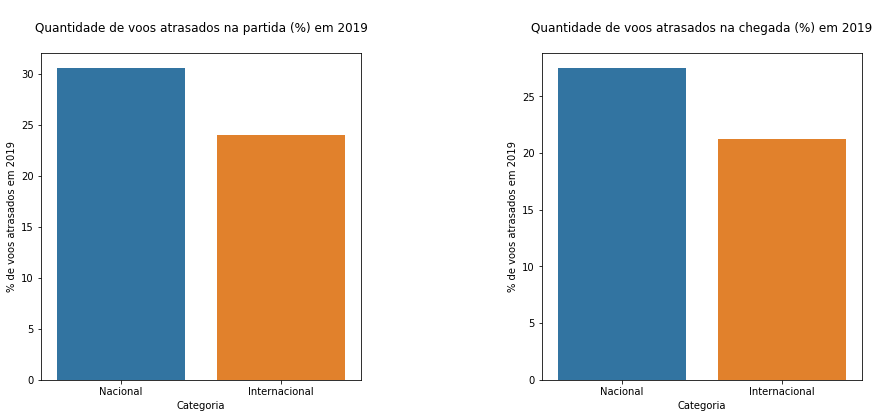

In [143]:
# Foram considerados apenas voos do tipo 'Nacional' e 'Internacional'
# Foram considerados apenas atrasos > 0 e <= 2880 min (2 dias) -- Desconsiderando voos adiantados e atrasos maiores que 2 dias erros de digitação/outliers 


voosatrasados_partida = data[['cidade_origem','dia', 'cd_tipo_linha']][(data['atraso_partida_min'] > 0) & (data['atraso_partida_min'] <= 2880) & (data['cd_tipo_linha'].isin(['Nacional', 'Internacional']))].groupby('cd_tipo_linha').count().reset_index()
voos_partida = data[['cd_tipo_linha','dia']].groupby('cd_tipo_linha').count().reset_index()
partida = voosatrasados_partida.merge(voos_partida, on = 'cd_tipo_linha')
partida['%'] = partida['dia_x']*100/partida['dia_y']
partida = partida.sort_values(by = '%', ascending = False).head(10)


voosatrasados_destino = data[['cidade_destino','dia', 'cd_tipo_linha']][(data['atraso_chegada_min'] > 0) & (data['atraso_chegada_min'] <= 2880) & (data['cd_tipo_linha'].isin(['Nacional', 'Internacional']))].groupby('cd_tipo_linha').count().reset_index()
voos_destino = data[['cd_tipo_linha','dia']].groupby('cd_tipo_linha').count().reset_index()
destino = voosatrasados_destino.merge(voos_destino, on = 'cd_tipo_linha')
destino['%'] = destino['dia_x']*100/destino['dia_y']
destino = destino.sort_values(by = '%', ascending = False).head(10)

fig, ax = plt.subplots(1,2, figsize = (16, 9))
fig.tight_layout(pad = 15)

sns.barplot(x = 'cd_tipo_linha', y = '%', data = partida, ax = ax[0])
ax[0].set_ylabel('% de voos atrasados em 2019')
ax[0].set_xlabel('Categoria')
ax[0].set_title('\nQuantidade de voos atrasados na partida (%) em 2019\n')

sns.barplot(x = 'cd_tipo_linha', y ='%', data = destino, ax = ax[1])
ax[1].set_ylabel('% de voos atrasados em 2019')
ax[1].set_xlabel('Categoria')
ax[1].set_title('\nQuantidade de voos atrasados na chegada (%) em 2019\n');

## Dia da semana com mais atrasos e atraso médio


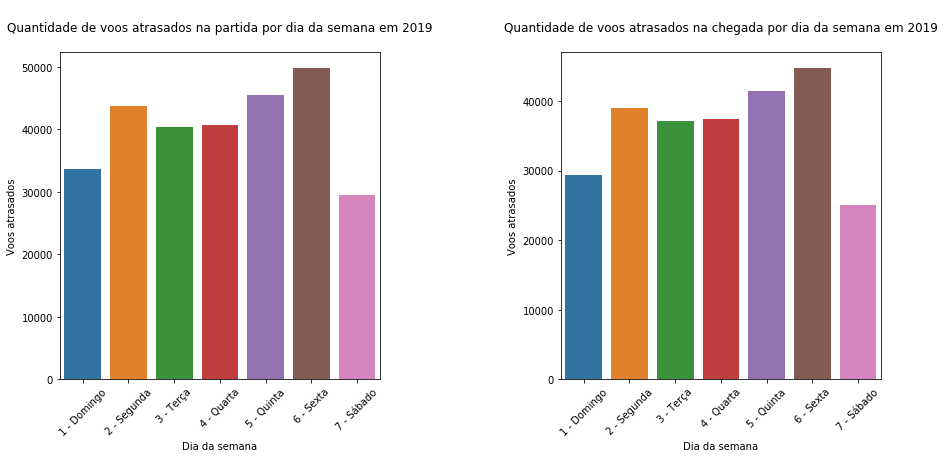

In [146]:
# Foram considerados apenas voos do tipo 'Nacional' e 'Internacional'
# Foram considerados apenas atrasos > 0 e <= 2880 min (2 dias) -- Desconsiderando voos adiantados e atrasos maiores que 2 dias erros de digitação/outliers 

partida = data[['cidade_origem','atraso_partida_min', 'cd_tipo_linha', 'dia_semana']][(data['atraso_partida_min'] > 0) & (data['atraso_partida_min'] <= 2880) & (data['cd_tipo_linha'].isin(['Nacional', 'Internacional']))].groupby('dia_semana').count().reset_index()
destino = data[['cidade_destino','atraso_chegada_min', 'cd_tipo_linha', 'dia_semana']][(data['atraso_chegada_min'] > 0) & (data['atraso_chegada_min'] <= 2880) & (data['cd_tipo_linha'].isin(['Nacional', 'Internacional']))].groupby('dia_semana').count().reset_index()

fig, ax = plt.subplots(1,2, figsize = (16, 9))
fig.tight_layout(pad = 15)

sns.barplot(y = 'atraso_partida_min', x = 'dia_semana', data = partida, ax = ax[0], )
ax[0].set_xlabel('Dia da semana')
ax[0].set_ylabel('Voos atrasados')
ax[0].set_title('\nQuantidade de voos atrasados na partida por dia da semana em 2019\n')
ax[0].set_xticklabels(partida['dia_semana'], rotation=45)


sns.barplot(y = 'atraso_chegada_min', x ='dia_semana', data = destino, ax = ax[1])
ax[1].set_xlabel('Dia da semana')
ax[1].set_ylabel('Voos atrasados')
ax[1].set_title('\nQuantidade de voos atrasados na chegada por dia da semana em 2019\n')
ax[1].set_xticklabels(destino['dia_semana'], rotation=45);

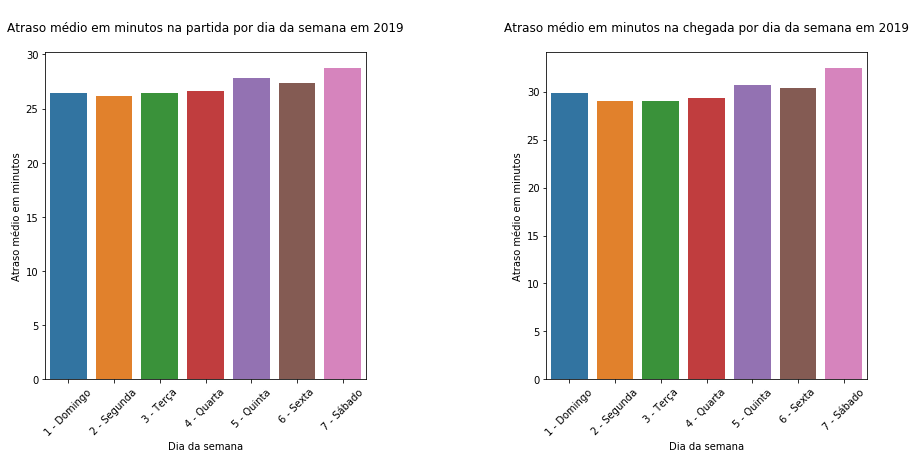

In [147]:
# Foram considerados apenas voos do tipo 'Nacional' e 'Internacional'
# Foram considerados apenas atrasos > 0 e <= 2880 min (2 dias) -- Desconsiderando voos adiantados e atrasos maiores que 2 dias erros de digitação/outliers 

partida = data[['cidade_origem','atraso_partida_min', 'cd_tipo_linha', 'dia_semana']][(data['atraso_partida_min'] > 0) & (data['atraso_partida_min'] <= 2880) & (data['cd_tipo_linha'].isin(['Nacional', 'Internacional']))].groupby('dia_semana').mean().reset_index()
destino = data[['cidade_destino','atraso_chegada_min', 'cd_tipo_linha', 'dia_semana']][(data['atraso_chegada_min'] > 0) & (data['atraso_chegada_min'] <= 2880) & (data['cd_tipo_linha'].isin(['Nacional', 'Internacional']))].groupby('dia_semana').mean().reset_index()

fig, ax = plt.subplots(1,2, figsize = (16, 9))
fig.tight_layout(pad = 15)

sns.barplot(y = 'atraso_partida_min', x = 'dia_semana', data = partida, ax = ax[0], )
ax[0].set_xlabel('Dia da semana')
ax[0].set_ylabel('Atraso médio em minutos')
ax[0].set_title('\nAtraso médio em minutos na partida por dia da semana em 2019\n')
ax[0].set_xticklabels(partida['dia_semana'], rotation=45)


sns.barplot(y = 'atraso_chegada_min', x ='dia_semana', data = destino, ax = ax[1])
ax[1].set_xlabel('Dia da semana')
ax[1].set_ylabel('Atraso médio em minutos')
ax[1].set_title('\nAtraso médio em minutos na chegada por dia da semana em 2019\n')
ax[1].set_xticklabels(destino['dia_semana'], rotation=45);

## Dia do mes com mais atrasos e atraso médio

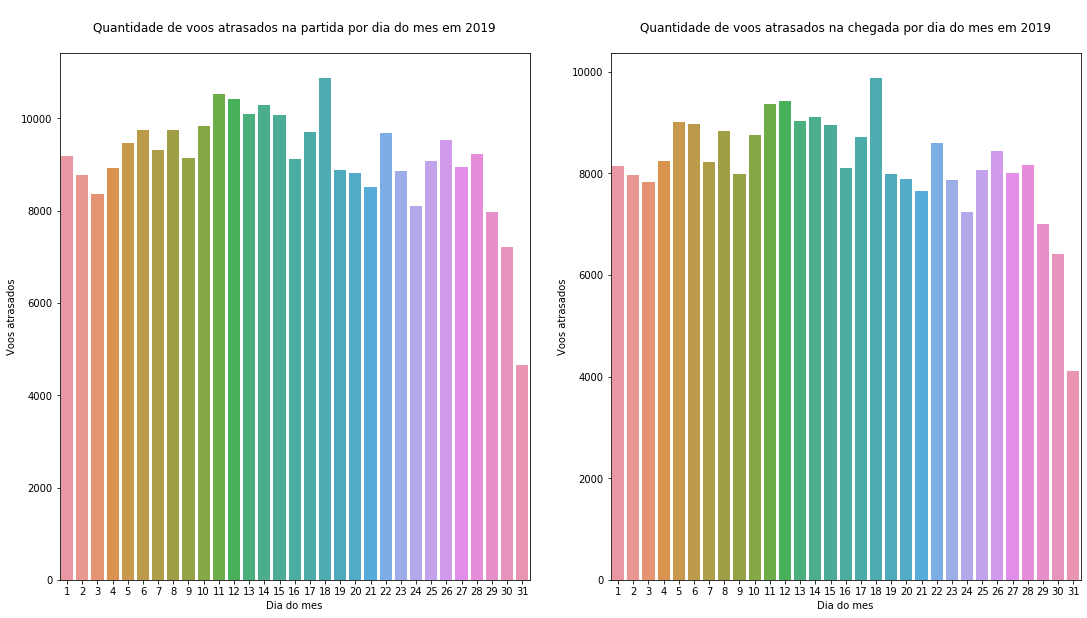

In [153]:
# Foram considerados apenas voos do tipo 'Nacional' e 'Internacional'
# Foram considerados apenas atrasos > 0 e <= 2880 min (2 dias) -- Desconsiderando voos adiantados e atrasos maiores que 2 dias erros de digitação/outliers 

partida = data[['cidade_origem','atraso_partida_min', 'cd_tipo_linha', 'dia']][(data['atraso_partida_min'] > 0) & (data['atraso_partida_min'] <= 2880) & (data['cd_tipo_linha'].isin(['Nacional', 'Internacional']))].groupby('dia').count().reset_index()
partida['dia'] = partida['dia'].astype('int64')
destino = data[['cidade_destino','atraso_chegada_min', 'cd_tipo_linha', 'dia']][(data['atraso_chegada_min'] > 0) & (data['atraso_chegada_min'] <= 2880) & (data['cd_tipo_linha'].isin(['Nacional', 'Internacional']))].groupby('dia').count().reset_index()
destino['dia'] = destino['dia'].astype('int64')

fig, ax = plt.subplots(1,2, figsize = (16, 9))
fig.tight_layout(pad = 5)

sns.barplot(y = 'atraso_partida_min', x = 'dia', data = partida, ax = ax[0], )
ax[0].set_xlabel('Dia do mes')
ax[0].set_ylabel('Voos atrasados')
ax[0].set_title('\nQuantidade de voos atrasados na partida por dia do mes em 2019\n')


sns.barplot(y = 'atraso_chegada_min', x ='dia', data = destino, ax = ax[1])
ax[1].set_xlabel('Dia do mes')
ax[1].set_ylabel('Voos atrasados')
ax[1].set_title('\nQuantidade de voos atrasados na chegada por dia do mes em 2019\n');


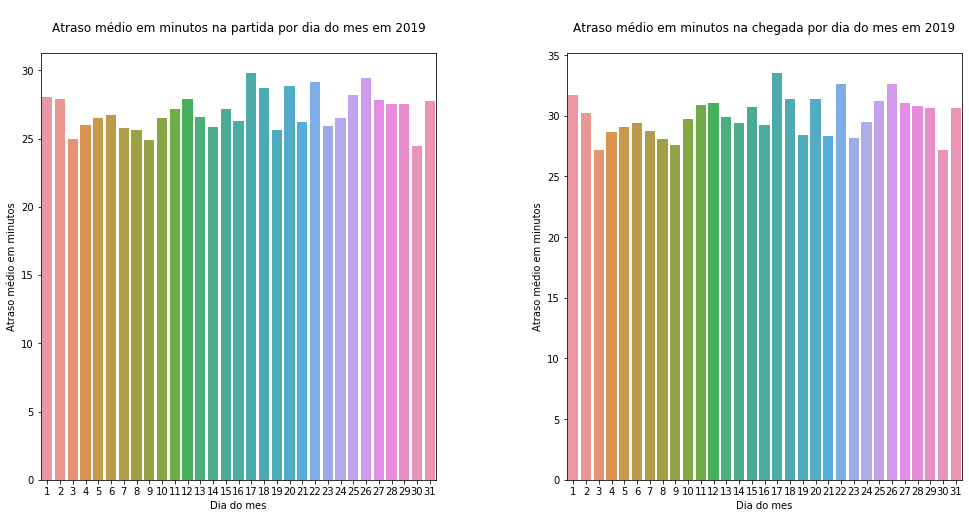

In [155]:
# Foram considerados apenas voos do tipo 'Nacional' e 'Internacional'
# Foram considerados apenas atrasos > 0 e <= 2880 min (2 dias) -- Desconsiderando voos adiantados e atrasos maiores que 2 dias erros de digitação/outliers 

partida = data[['cidade_origem','atraso_partida_min', 'cd_tipo_linha', 'dia']][(data['atraso_partida_min'] > 0) & (data['atraso_partida_min'] <= 2880) & (data['cd_tipo_linha'].isin(['Nacional', 'Internacional']))].groupby('dia').mean().reset_index()
partida['dia'] = partida['dia'].astype('int64')

destino = data[['cidade_destino','atraso_chegada_min', 'cd_tipo_linha', 'dia']][(data['atraso_chegada_min'] > 0) & (data['atraso_chegada_min'] <= 2880) & (data['cd_tipo_linha'].isin(['Nacional', 'Internacional']))].groupby('dia').mean().reset_index()
destino['dia'] = destino['dia'].astype('int64')

fig, ax = plt.subplots(1,2, figsize = (16, 9))
fig.tight_layout(pad = 10)

sns.barplot(y = 'atraso_partida_min', x = 'dia', data = partida, ax = ax[0], )
ax[0].set_xlabel('Dia do mes')
ax[0].set_ylabel('Atraso médio em minutos')
ax[0].set_title('\nAtraso médio em minutos na partida por dia do mes em 2019\n')


sns.barplot(y = 'atraso_chegada_min', x ='dia', data = destino, ax = ax[1])
ax[1].set_xlabel('Dia do mes')
ax[1].set_ylabel('Atraso médio em minutos')
ax[1].set_title('\nAtraso médio em minutos na chegada por dia do mes em 2019\n');

## Atrasos por mes e minutos de atraso por mes

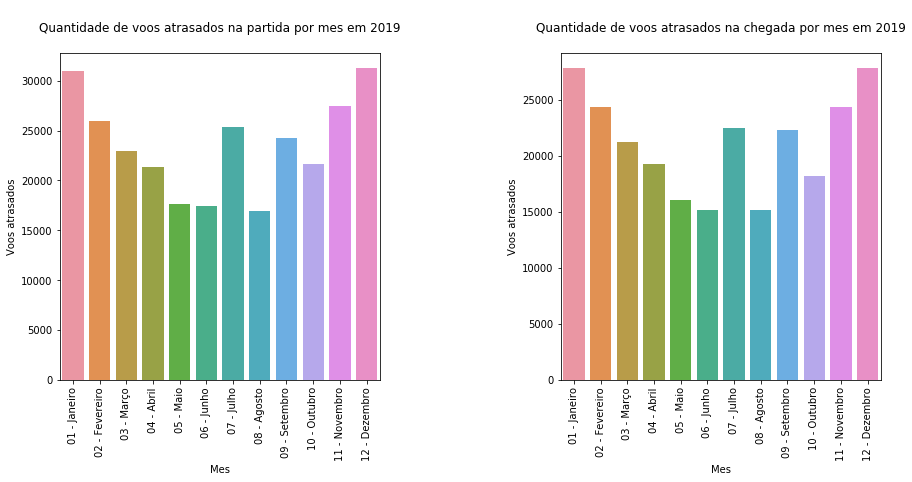

In [167]:
# Foram considerados apenas voos do tipo 'Nacional' e 'Internacional'
# Foram considerados apenas atrasos > 0 e <= 2880 min (2 dias) -- Desconsiderando voos adiantados e atrasos maiores que 2 dias erros de digitação/outliers 

partida = data[['cidade_origem','atraso_partida_min', 'cd_tipo_linha', 'mes']][(data['atraso_partida_min'] > 0) & (data['atraso_partida_min'] <= 2880) & (data['cd_tipo_linha'].isin(['Nacional', 'Internacional']))].groupby('mes').count().reset_index()
destino = data[['cidade_destino','atraso_chegada_min', 'cd_tipo_linha', 'mes']][(data['atraso_chegada_min'] > 0) & (data['atraso_chegada_min'] <= 2880) & (data['cd_tipo_linha'].isin(['Nacional', 'Internacional']))].groupby('mes').count().reset_index()

fig, ax = plt.subplots(1,2, figsize = (16, 9))
fig.tight_layout(pad = 15)

sns.barplot(y = 'atraso_partida_min', x = 'mes', data = partida, ax = ax[0], )
ax[0].set_xlabel('Mes')
ax[0].set_ylabel('Voos atrasados')
ax[0].set_title('\nQuantidade de voos atrasados na partida por mes em 2019\n')
ax[0].set_xticklabels(partida['mes'], rotation=90)


sns.barplot(y = 'atraso_chegada_min', x ='mes', data = destino, ax = ax[1])
ax[1].set_xlabel('Mes')
ax[1].set_ylabel('Voos atrasados')
ax[1].set_title('\nQuantidade de voos atrasados na chegada por mes em 2019\n')
ax[1].set_xticklabels(destino['mes'], rotation=90);

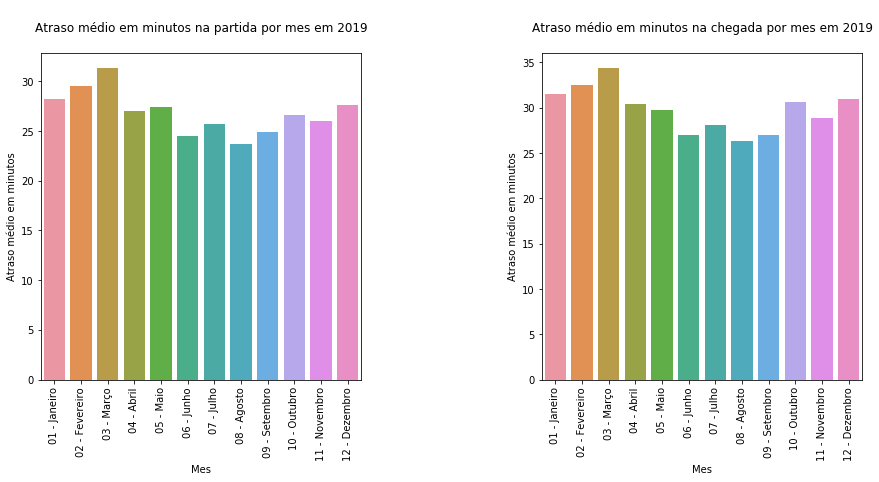

In [166]:
# Foram considerados apenas voos do tipo 'Nacional' e 'Internacional'
# Foram considerados apenas atrasos > 0 e <= 2880 min (2 dias) -- Desconsiderando voos adiantados e atrasos maiores que 2 dias erros de digitação/outliers 

partida = data[['cidade_origem','atraso_partida_min', 'cd_tipo_linha', 'mes']][(data['atraso_partida_min'] > 0) & (data['atraso_partida_min'] <= 2880) & (data['cd_tipo_linha'].isin(['Nacional', 'Internacional']))].groupby('mes').mean().reset_index()
destino = data[['cidade_destino','atraso_chegada_min', 'cd_tipo_linha', 'mes']][(data['atraso_chegada_min'] > 0) & (data['atraso_chegada_min'] <= 2880) & (data['cd_tipo_linha'].isin(['Nacional', 'Internacional']))].groupby('mes').mean().reset_index()

fig, ax = plt.subplots(1,2, figsize = (16, 9))
fig.tight_layout(pad = 15)

sns.barplot(y = 'atraso_partida_min', x = 'mes', data = partida, ax = ax[0], )
ax[0].set_xlabel('Mes')
ax[0].set_ylabel('Atraso médio em minutos')
ax[0].set_title('\nAtraso médio em minutos na partida por mes em 2019\n')
ax[0].set_xticklabels(partida['mes'], rotation=90)


sns.barplot(y = 'atraso_chegada_min', x ='mes', data = destino, ax = ax[1])
ax[1].set_xlabel('Mes')
ax[1].set_ylabel('Atraso médio em minutos')
ax[1].set_title('\nAtraso médio em minutos na chegada por mes em 2019\n')
ax[1].set_xticklabels(destino['mes'], rotation=90);